Train/Val shapes: (1283, 75, 75, 3) (321, 75, 75, 3) 602 151


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ inc_angle           │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ image (InputLayer)  │ (None, 224, 224,  │          0 │ -                 │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 16)        │         32 │ inc_angle[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resnet50v2          │ (None, 2048)      │ 23,564,800 │ image[0][0]       │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 8)         │        136 │ dense_8[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 2056)      │          0 │ resnet50v2[0][0], │
│ (Concatenate)       │                   │            │ dense_9[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_10 (Dense)    │ (None, 128)       │    263,296 │ concatenate_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 128)       │          0 │ dense_10[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_11 (Dense)    │ (None, 64)        │      8,256 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ out (Dense)         │ (None, 1)         │         65 │ dense_11[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 23,836,585 (90.93 MB)

 Trainable params: 271,785 (1.04 MB)

 Non-trainable params: 23,564,800 (89.89 MB)

class_weight: {0: np.float64(0.9419970631424376), 1: np.float64(1.0656146179401993)}
Epoch 1/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 35s 732ms/step - accuracy: 0.5791 - auc: 0.6222 - loss: 0.6694 - val_accuracy: 0.7072 - val_auc: 0.8300 - val_loss: 0.5762 - learning_rate: 1.0000e-04
Epoch 2/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 29s 713ms/step - accuracy: 0.7202 - auc: 0.8114 - loss: 0.5449 - val_accuracy: 0.7632 - val_auc: 0.8524 - val_loss: 0.4881 - learning_rate: 1.0000e-04
Epoch 3/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 32s 777ms/step - accuracy: 0.7436 - auc: 0.8433 - loss: 0.4868 - val_accuracy: 0.7726 - val_auc: 0.8675 - val_loss: 0.4511 - learning_rate: 1.0000e-04
Epoch 4/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 30s 721ms/step - accuracy: 0.7553 - auc: 0.8554 - loss: 0.4649 - val_accuracy: 0.7788 - val_auc: 0.8758 - val_loss: 0.4376 - learning_rate: 1.0000e-04
Epoch 5/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 30s 725ms/step - accuracy: 0.7677 - auc: 0.8678 - loss: 0.4475 - val_accuracy: 0.7726 - val_auc: 0.8821 - val_loss: 0.420

2025-11-18 19:55:06.473206: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


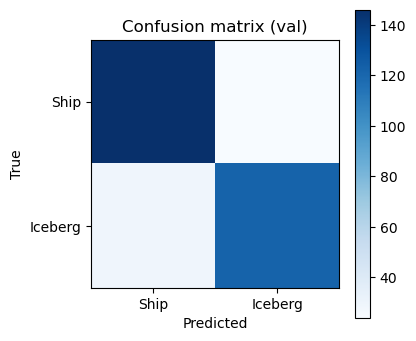

In [9]:
import os
import json
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.applications.resnet_v2 import ResNet50V2, preprocess_input
import matplotlib.pyplot as plt

SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

# ---------------------------
# 1) Load dataframes
# ---------------------------
train_df = pd.read_json("train.json")
test_df  = pd.read_json("test.json")

# Convert inc_angle to numeric and fill missing with median (from train)
train_df["inc_angle"] = pd.to_numeric(train_df["inc_angle"], errors="coerce")
angle_median = train_df["inc_angle"].median()
train_df["inc_angle"] = train_df["inc_angle"].fillna(angle_median)

test_df["inc_angle"] = pd.to_numeric(test_df["inc_angle"], errors="coerce")
test_df["inc_angle"] = test_df["inc_angle"].fillna(angle_median)  # IMPORTANT: use train statistic

# ---------------------------
# 2) Build image arrays (75x75)
#    We stack band1, band2, and avg(band1,band2) into 3 channels
# ---------------------------
def build_images(df):
    imgs = []
    for _, r in df.iterrows():
        b1 = np.array(r["band_1"], dtype=np.float32).reshape(75,75)
        b2 = np.array(r["band_2"], dtype=np.float32).reshape(75,75)
        c3 = 0.5*(b1 + b2)
        img = np.stack([b1, b2, c3], axis=-1)   # shape (75,75,3)
        imgs.append(img)
    return np.stack(imgs, axis=0)  # (N,75,75,3)

X = build_images(train_df)
X_test = build_images(test_df)

angles = train_df["inc_angle"].values.astype(np.float32).reshape(-1,1)
angles_test = test_df["inc_angle"].values.astype(np.float32).reshape(-1,1)
y = train_df["is_iceberg"].values.astype(np.int32)

# ---------------------------
# 3) train/val split
# ---------------------------
X_train, X_val, ang_train, ang_val, y_train, y_val = train_test_split(
    X, angles, y, test_size=0.20, random_state=SEED, stratify=y
)

print("Train/Val shapes:", X_train.shape, X_val.shape, y_train.sum(), y_val.sum())

# ---------------------------
# 4) tf.data pipeline
#    We'll scale to [0,255] and then preprocess_input for imagenet
# ---------------------------

IMG_SIZE = (224,224)
BATCH = 32
AUTOTUNE = tf.data.AUTOTUNE

def preprocess_fn(image, angle, label=None, augment=False):
    
    image = tf.cast(image, tf.float32)
    
    minv = tf.reduce_min(image, axis=[0,1], keepdims=True)
    maxv = tf.reduce_max(image, axis=[0,1], keepdims=True)
    image = (image - minv) / (maxv - minv + 1e-6)
    image = image * 255.0
    image = tf.image.resize(image, IMG_SIZE, method='bilinear')
    
    if augment:
        image = tf.image.random_flip_left_right(image)
        image = tf.image.random_flip_up_down(image)
        image = tf.image.rot90(image, k=tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32))
        # small random brightness/contrast
        image = tf.image.random_brightness(image, max_delta=0.05)
        image = tf.image.random_contrast(image, lower=0.95, upper=1.05)
    
    # preprocess for ResNet (subtract mean, etc.)
    image = preprocess_input(image)
    
    # normalize angle (use train median/std)
    angle = tf.cast(angle, tf.float32)
    return (image, angle) if label is None else ((image, angle), label)

def make_dataset(Xa, angles_a, ya=None, batch=BATCH, shuffle=False, augment=False):
    if ya is None:
        ds = tf.data.Dataset.from_tensor_slices((Xa, angles_a))
        ds = ds.map(lambda a,b: preprocess_fn(a,b, label=None, augment=False), num_parallel_calls=AUTOTUNE)
        ds = ds.batch(batch).prefetch(AUTOTUNE)
        return ds
    ds = tf.data.Dataset.from_tensor_slices((Xa, angles_a, ya))
    if shuffle:
        ds = ds.shuffle(2048, seed=SEED)
    ds = ds.map(lambda a,b,c: preprocess_fn(a,b,label=c, augment=augment), num_parallel_calls=AUTOTUNE)
    ds = ds.batch(batch).prefetch(AUTOTUNE)
    return ds

train_ds = make_dataset(X_train, ang_train, y_train, batch=BATCH, shuffle=True, augment=True)
val_ds   = make_dataset(X_val,   ang_val,   y_val,   batch=BATCH, shuffle=False, augment=False)
test_ds  = make_dataset(X_test,  angles_test, ya=None, batch=BATCH)

# ---------------------------
# 5) Build the model (ResNet backbone + small MLP for angle)
# ---------------------------
def build_model(input_shape=(224,224,3), use_angle=True, freeze_backbone=True):
    img_in = layers.Input(shape=input_shape, name="image")
    angle_in = layers.Input(shape=(1,), name="inc_angle") if use_angle else None

    backbone = ResNet50V2(include_top=False, weights="imagenet", pooling="avg")
    if freeze_backbone:
        backbone.trainable = False

    feat = backbone(img_in) 
    if use_angle:
        a = layers.Normalization(axis=None, name="angle_norm")
        # fit will be called later to set mean/variance; instead we do simple standardization manually below
        # small mlp
        a_dense = layers.Dense(16, activation="relu")(angle_in)
        a_dense = layers.Dense(8, activation="relu")(a_dense)
        x = layers.Concatenate()([feat, a_dense])
    else:
        x = feat

    x = layers.Dense(128, activation="relu")(x)
    x = layers.Dropout(0.4)(x)
    x = layers.Dense(64, activation="relu")(x)
    out = layers.Dense(1, activation="sigmoid", name="out")(x)

    model = models.Model(inputs=[img_in, angle_in] if use_angle else img_in, outputs=out)
    return model

model = build_model(freeze_backbone=True)
model.summary()

# ---------------------------
# 6) Prepare callbacks and compile
# ---------------------------

checkpoint = callbacks.ModelCheckpoint("best_resnet_iceberg.keras", monitor="val_auc", mode="max",
                                       save_best_only=True, save_weights_only=False)
es = callbacks.EarlyStopping(monitor="val_auc", mode="max", patience=6, restore_best_weights=True)
rlr = callbacks.ReduceLROnPlateau(monitor="val_auc", mode="max", factor=0.5, patience=3)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss="binary_crossentropy",
    metrics=[tf.keras.metrics.BinaryAccuracy(name="accuracy"), tf.keras.metrics.AUC(name="auc")]
)

# ---------------------------
# 7) Compute class weights 
# ---------------------------
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(y_train), y=y_train)
class_weight_dict = {0: class_weights[0], 1: class_weights[1]}
print("class_weight:", class_weight_dict)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30,
    class_weight=class_weight_dict,
    callbacks=[checkpoint, es, rlr]
)

# Unfreeze backbone for fine-tune
model.layers[2].trainable = True   
model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
              loss="binary_crossentropy",
              metrics=[tf.keras.metrics.BinaryAccuracy(name="accuracy"), tf.keras.metrics.AUC(name="auc")])
history2 = model.fit(train_ds, validation_data=val_ds, epochs=10, callbacks=[checkpoint, es, rlr], class_weight=class_weight_dict)

# ---------------------------
# 8) Evaluate on validation set
# ---------------------------

y_true = []
y_prob = []
for (img_batch, ang_batch), label_batch in val_ds:
    p = model.predict_on_batch([img_batch, ang_batch])
    y_prob.append(p.ravel())
    y_true.append(label_batch.numpy())
y_prob = np.concatenate(y_prob)
y_true = np.concatenate(y_true)
y_pred = (y_prob >= 0.5).astype(int)

print("Val ROC AUC:", roc_auc_score(y_true, y_prob))
print(classification_report(y_true, y_pred, digits=4))
cm = confusion_matrix(y_true, y_pred)
print("Confusion matrix:\n", cm)

# plot confusion matrix
import matplotlib.pyplot as plt
plt.figure(figsize=(4,4))
plt.imshow(cm, cmap="Blues", interpolation="nearest")
plt.colorbar()
plt.xticks([0,1], ["Ship","Iceberg"])
plt.yticks([0,1], ["Ship","Iceberg"])
plt.xlabel("Predicted"); plt.ylabel("True")
plt.title("Confusion matrix (val)")
plt.savefig("confusion_matrix_val.png", dpi=150)

In [11]:
# SVM Baseline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from skimage.feature import graycomatrix, graycoprops


df = pd.read_json("train.json")
df["inc_angle"] = pd.to_numeric(df["inc_angle"], errors="coerce")
df["inc_angle"] = df["inc_angle"].fillna(df["inc_angle"].median())


def extract_stats(arr):
    """Mean, std, max, min, median."""
    return [
        np.mean(arr),
        np.std(arr),
        np.max(arr),
        np.min(arr),
        np.median(arr)
    ]

def extract_glcm_features(arr):
    """Compute GLCM texture features."""
    
    arr8 = (255*(arr - arr.min())/(arr.max() - arr.min() + 1e-6)).astype(np.uint8)

    glcm = graycomatrix(arr8, distances=[1], angles=[0], levels=256, symmetric=True, normed=True)

    feats = [
        graycoprops(glcm, 'contrast')[0,0],
        graycoprops(glcm, 'dissimilarity')[0,0],
        graycoprops(glcm, 'homogeneity')[0,0],
        graycoprops(glcm, 'energy')[0,0],
        graycoprops(glcm, 'ASM')[0,0],
        graycoprops(glcm, 'correlation')[0,0]
    ]
    return feats

# --------------------------
# Build feature matrix
# --------------------------
feature_list = []

for i, row in df.iterrows():
    b1 = np.array(row["band_1"]).reshape(75,75)
    b2 = np.array(row["band_2"]).reshape(75,75)

    feats = []
    feats += extract_stats(b1)
    feats += extract_stats(b2)
    feats += extract_glcm_features(b1)
    feats += extract_glcm_features(b2)
    feats.append(row["inc_angle"])

    feature_list.append(feats)

X = np.array(feature_list)
y = df["is_iceberg"].values

print("Feature matrix shape:", X.shape)


# Train/val split (STRATIFIED)

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


# Scale features

scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train)
X_val_sc   = scaler.transform(X_val)


# Train SVM (balanced classes)

svm_clf = SVC(
    kernel="rbf",
    C=2.0,
    gamma="scale",
    probability=True,
    class_weight="balanced"
)

svm_clf.fit(X_train_sc, y_train)


# Evaluation

y_pred = svm_clf.predict(X_val_sc)
y_prob = svm_clf.predict_proba(X_val_sc)[:,1]

print("\n===== SVM Classification Report =====")
print(classification_report(y_val, y_pred, digits=4))

print("ROC AUC:", roc_auc_score(y_val, y_prob))

cm = confusion_matrix(y_val, y_pred)
print("\nConfusion Matrix:\n", cm)


Feature matrix shape: (1604, 23)

===== SVM Classification Report =====
              precision    recall  f1-score   support

           0     0.9226    0.9118    0.9172       170
           1     0.9020    0.9139    0.9079       151

    accuracy                         0.9128       321
   macro avg     0.9123    0.9128    0.9125       321
weighted avg     0.9129    0.9128    0.9128       321

ROC AUC: 0.9664978574211142

Confusion Matrix:
 [[155  15]
 [ 13 138]]
